# Unusual Repeated Streak (QAQC)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import datetime as dt
import scipy
from IPython.display import Image

%matplotlib inline
%load_ext autoreload
%autoreload 2

## From HadISD paper:

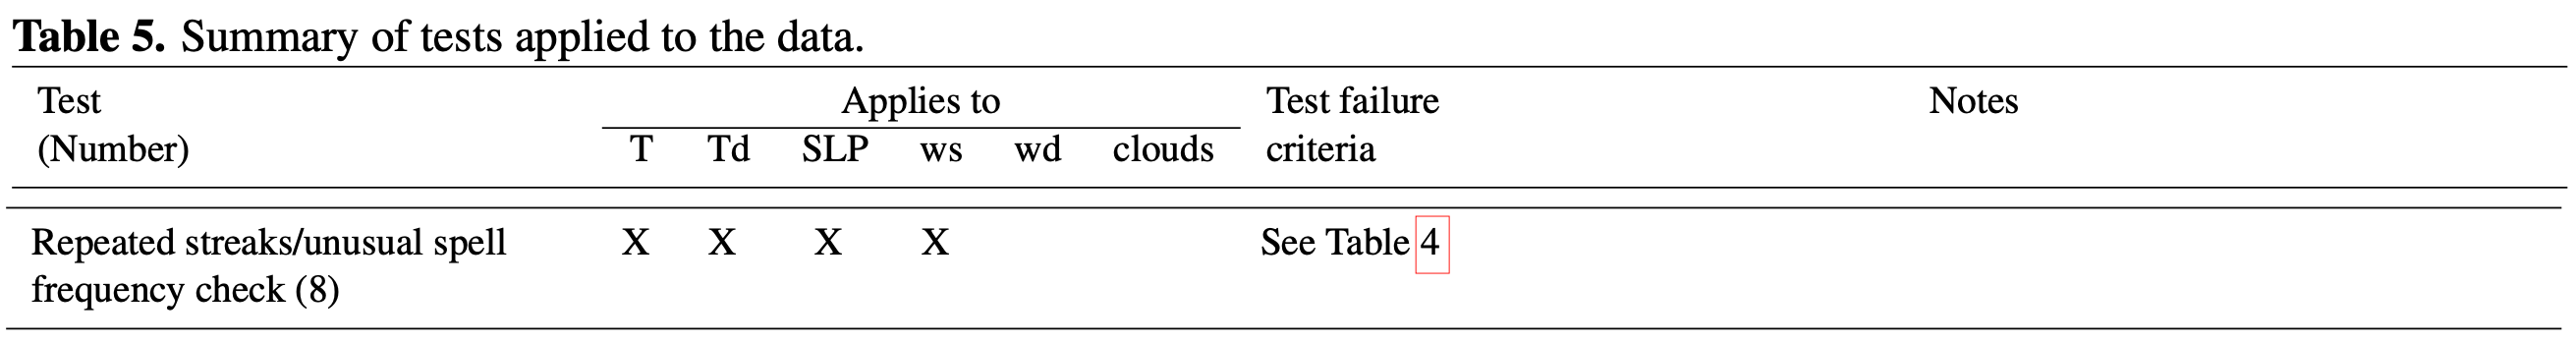

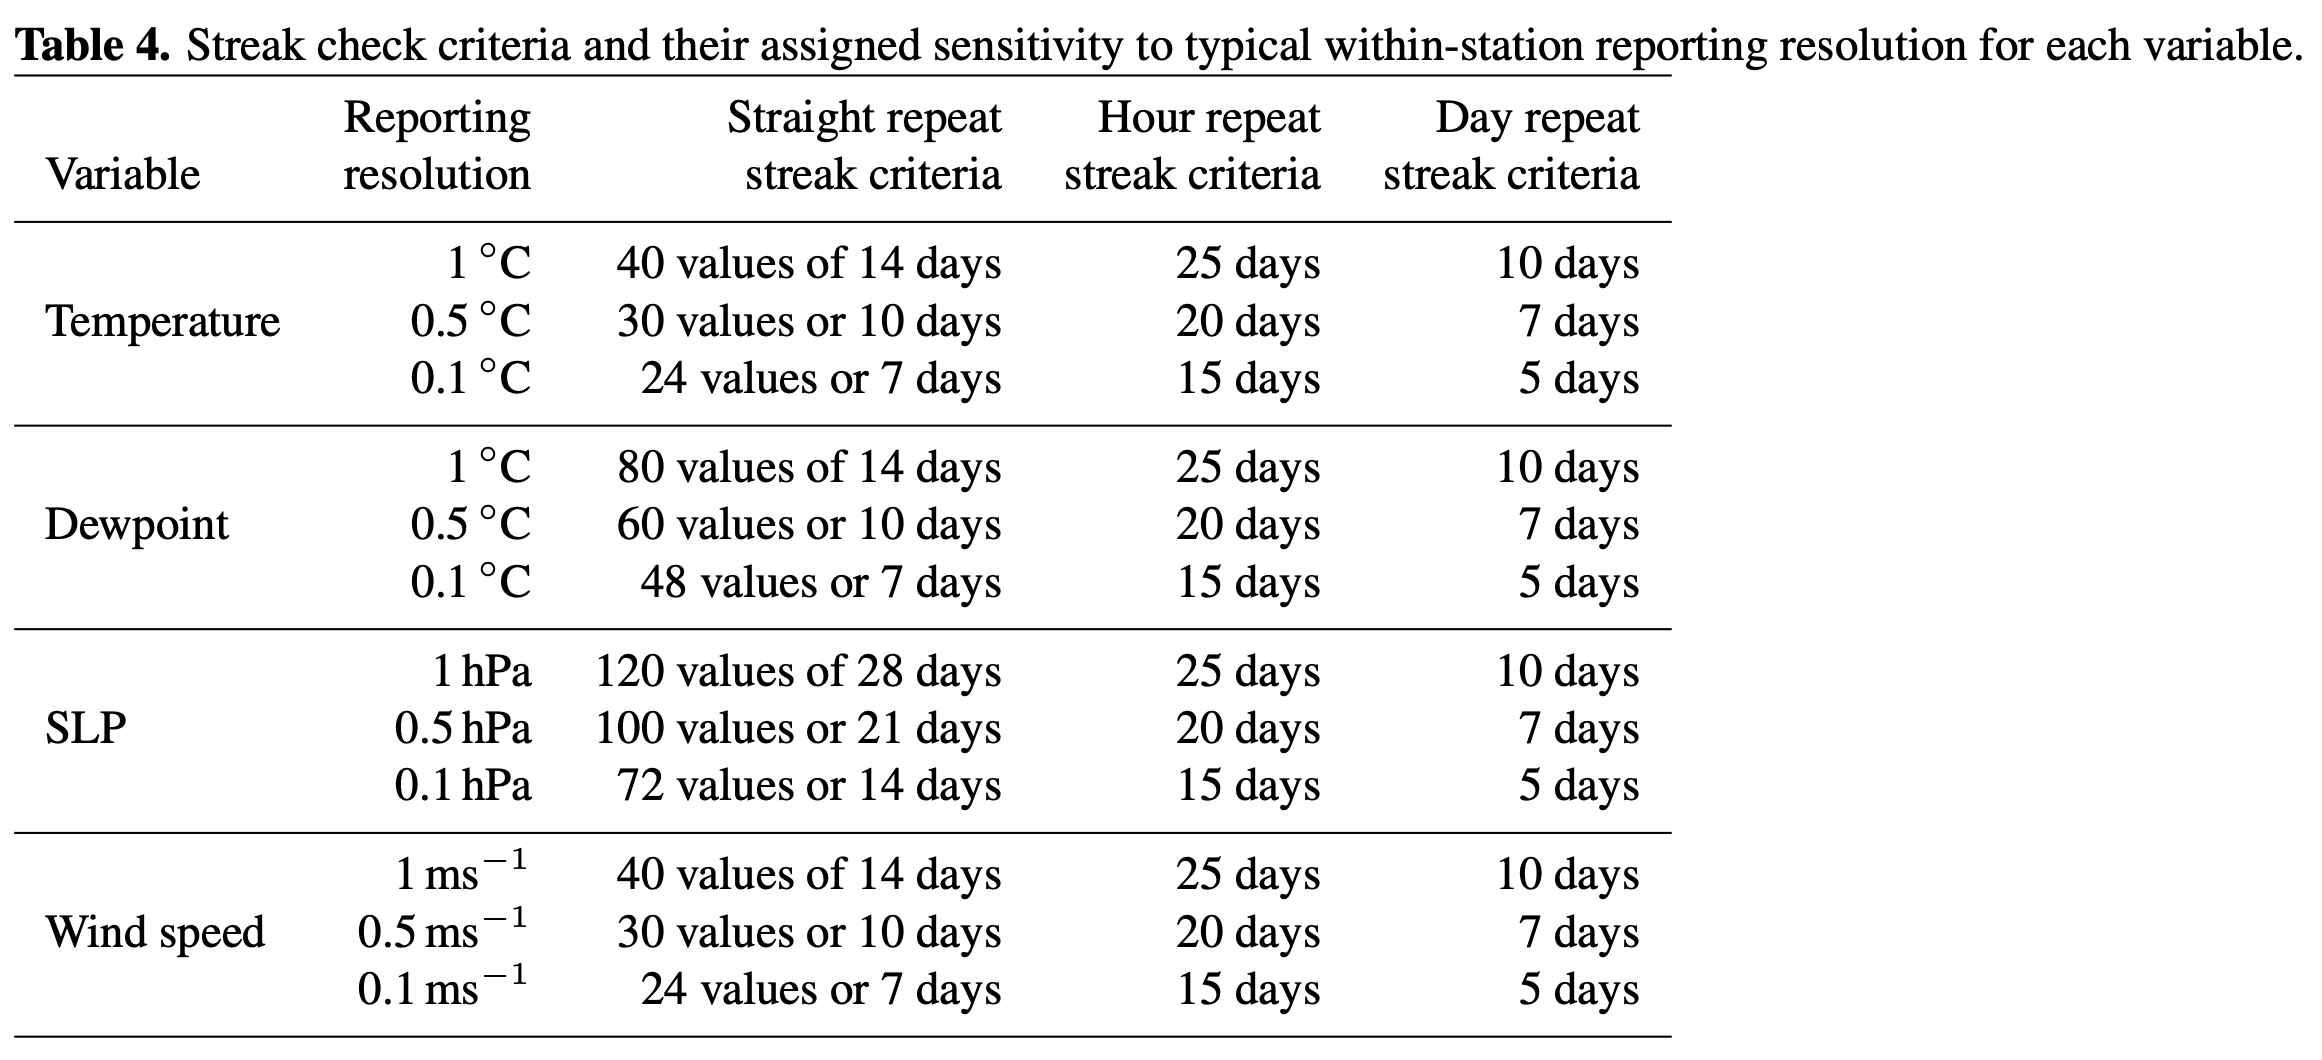

In [2]:
display(Image(filename="/Users/hector/ERA_work/Table5.png"))
display(Image(filename="/Users/hector/ERA_work/Table4.png"))

##### Test 8: repeated streaks/unusual spell frequency

<div style="display: flex;">
    <span style="width: 59%"><p size="+4.75">This test searches for consecutive observation replication, same hour observation replication over, a number of days (either using a threshold of a certain number of observations, or for sparser records, a number of days during which all the observations have the same value) and also whole day replication for a streak of days. All three tests are conditional upon the typical reporting precision as coarser precision reporting (e.g. temperatures only to the nearest whole degree) will increase the chances of a streak arising by chance (Table 4).</p></span> 
</div>


In [3]:
#---------------------------------------------------------------------------------------------------
def qaqc_world_record(df, verbose=True):
    '''
    Checks if temperature, dewpoint, windspeed, or sea level pressure are outside North American world records
    If outside minimum or maximum records, flags values
    '''
    try:
        # world records from HadISD protocol, cross-checked with WMO database
        # https://wmo.asu.edu/content/world-meteorological-organization-global-weather-climate-extremes-archive
        T_X = {"North_America":329.92} #K
        T_N = {"North_America":210.15} #K
        D_X = {"North_America":329.85} #K
        D_N = {"North_America":173.15} #K
        W_X = {"North_America":113.2} #m/s
        W_N = {"North_America":0.} #m/s
        S_X = {"North_America":108330} #Pa
        S_N = {"North_America":87000} #Pa

        maxes = {"tas": T_X, "tdps": D_X, "tdps_derived": D_X, "sfcWind": W_X, "psl": S_X, "ps": S_X}
        mins =  {"tas": T_N, "tdps": D_N, "tdps_derived": D_N, "sfcWind": W_N, "psl": S_N, "ps": S_N}

        # variable names to check against world record limits
        wr_vars = ['tas', 'tdps_derived', 'tdps', 'sfcWind', 'psl', 'ps']

        for var in wr_vars:
            if var in list(df.columns):
                                
                isOffRecord = np.logical_or(df[var] < mins[var]['North_America'],
                                            df[var] > maxes[var]['North_America'])
                if isOffRecord.any():
                    df.loc[isOffRecord, var + '_eraqc'] = 11
        return df
    except Exception as e:
        if verbose:
            print("qaqc_world_record failed with Exception: {}".format(e))
        return None
    

In [73]:
def xarray_to_pandas_qaqc_old(ds):
    """
    """

    ## Add qc_flag variable for all variables, including elevation; 
    ## defaulting to nan for fill value that will be replaced with qc flag
    exclude_qaqc = ["time", "station", "lat", "lon", 
                    "qaqc_process", "sfcWind_method"] # lat and lon have a different qc check

    raw_qc_vars = [] # qc_variable for each data variable, will vary station to station
    era_qc_vars = [] # our qc variable
    for var in ds.data_vars:
        if 'q_code' in var:
            raw_qc_vars.append(var) # raw qc variable, need to keep for comparison, then drop
        if '_qc' in var:
            raw_qc_vars.append(var) # raw qc variables, need to keep for comparison, then drop

    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars:
            qc_var = var + "_eraqc" # variable/column label
            era_qc_vars.append(qc_var)
            # adds new variable in shape of original variable with designated nan fill value
            ds = ds.assign({qc_var: xr.ones_like(ds[var])*np.nan})

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var:ds[var].attrs for var in list(ds.data_vars.keys())}

    df = ds.to_dataframe()
    df['anemometer_height_m'] = np.ones(ds['time'].shape)*ds.anemometer_height_m
    df['thermometer_height_m'] = np.ones(ds['time'].shape)*ds.thermometer_height_m
    
    return df

In [64]:
def xarray_to_pandas_qaqc(ds):
    """
    """

    ## Add qc_flag variable for all variables, including elevation; 
    ## defaulting to nan for fill value that will be replaced with qc flag
    exclude_qaqc = ["time", "station", "lat", "lon", 
                    "qaqc_process", "sfcWind_method"] # lat and lon have a different qc check

    raw_qc_vars = [] # qc_variable for each data variable, will vary station to station
    era_qc_vars = [] # our qc variable
    for var in ds.data_vars:
        if 'q_code' in var:
            raw_qc_vars.append(var) # raw qc variable, need to keep for comparison, then drop
        if '_qc' in var:
            raw_qc_vars.append(var) # raw qc variables, need to keep for comparison, then drop

    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars:
            qc_var = var + "_eraqc" # variable/column label
            era_qc_vars.append(qc_var)
            # adds new variable in shape of original variable with designated nan fill value
            ds = ds.assign({qc_var: xr.ones_like(ds[var])*np.nan})

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var:ds[var].attrs for var in list(ds.data_vars.keys())}

    df = ds.to_dataframe()
    df['anemometer_height_m'] = np.ones(ds['time'].shape)*ds.anemometer_height_m
    df['thermometer_height_m'] = np.ones(ds['time'].shape)*ds.thermometer_height_m
    
    # Save station/time multiindex
    MultiIndex = df.index
    station = df.index.get_level_values(0)
    df['station'] = station
    
    # Station pd.Series to str
    station = station.unique().values[0]
    
    # Convert time/station index to columns and reset index
    df = df.droplevel(0).reset_index()
    
    return df

In [74]:
ds = xr.open_dataset('train_files/RAWS_ZMBA2.nc')
ds = xr.open_dataset('train_files/RAWS_PKLC2.nc')
ds = xr.open_dataset('train_files/ASOSAWOS_72274793084.nc')

In [155]:
df = xarray_to_pandas_qaqc(ds)
df_old = xarray_to_pandas_qaqc_old(ds.isel(station=0))

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [83]:
df = qaqc_world_record(df)
print(len(np.where(~np.isnan(df.tas_eraqc))[0]))
# new_df = unusual_large_jumps(new_df)
# print(len(np.where(~np.isnan(new_df.tas_eraqc))[0]))

0


### Infere time frequency from data

In [156]:
def infere_freq(df):
    """
    """
    # Calculate time differences in data
    time_diff = pd.Series(df['time']).diff()

    # Count resolution occurences and use only those that occure in 5% of series or more
    frequencies = time_diff.value_counts()
    frequencies = frequencies[frequencies > len(df)//5]

    # Create resolutions dictionary
    frequencies = {
                   np.round(n/len(df), decimals=5):float(f/1e9) for 
                   n,f in zip(frequencies.values,
                             frequencies.index.values)
                  }
    
    return frequencies

In [157]:
infere_freq(df), infere_freq_old(df_old)

({0.85393: 3600.0}, {0.85393: 3600.0})

### Infere variable resolution from data

In [158]:
def infere_res_var(df, var):
    """
    """
    # If var is tdps_derived, use temp measurements
    if var == "tdps_derived":
        var = "tas"
    
    # Extract var data   
    data = df.copy()[var]
    
    # Convert from Pa to hPa
    if data.mean()>10000 and (var=="ps" or var=="slp"):
        data = data/100
    
    # Calculate modified mode from avg mode and median
    mode0 = data.sort_values().diff().replace(0, pd.NaT).mode().values[0]
    mode1 = data.sort_values().diff().replace(0, pd.NaT).median()
    mode = (mode0+mode1)/2
    
    # Round to the nearest 0.5
    multiplied = round(mode * 2)
    rounded_to_whole = multiplied / 2
    
    # If mode is 0.25 or less, round to 0.1
    if rounded_to_whole == 0:
        mode = 0.1
    else:
        mode = rounded_to_whole
    return mode

In [159]:
def infere_res(df):
    """
    """
    variables = ["tas", "tdps", "tdps_derived", "ps", "slp", "sfcWind"]
    resolutions = {}

    for var in variables:
        if var in df.columns:
            resolutions[var] = infere_res_var(df, var)

    return resolutions

In [160]:
infere_res(df)

{'tas': 0.5, 'tdps': 0.5, 'ps': 0.5, 'sfcWind': 0.5}

In [161]:
# Straight repeat streak criteria

straight_repeat_criteria = {"tas" : {1  : [40, 14],   # 40 values of 14 days
                                     0.5 : [30, 10],  # 30 values or 10 days
                                     0.1 : [24,  7],  # 24 values or 7 days
                           },
                            "tdps" : {1  : [80, 14],  # of
                                      0.5 : [60, 10], # or
                                      0.1 : [48,  7], # or
                                             },
                            "slp" : {1   : [120, 28],  # of
                                     0.5 : [100, 21],  # or
                                     0.1 : [ 72, 14]}, # or
         
                            "sfcWind" : {1   : [40, 14], # of
                                         0.5 : [30, 10], # or
                                         0.1 : [24,  7], # or
                                        },
                           }
straight_repeat_criteria['tdps_derived'] = straight_repeat_criteria['tdps']
straight_repeat_criteria['ps'] = straight_repeat_criteria['slp']
straight_repeat_criteria['sfcWind'] = straight_repeat_criteria['tas']
straight_repeat_criteria

{'tas': {1: [40, 14], 0.5: [30, 10], 0.1: [24, 7]},
 'tdps': {1: [80, 14], 0.5: [60, 10], 0.1: [48, 7]},
 'slp': {1: [120, 28], 0.5: [100, 21], 0.1: [72, 14]},
 'sfcWind': {1: [40, 14], 0.5: [30, 10], 0.1: [24, 7]},
 'tdps_derived': {1: [80, 14], 0.5: [60, 10], 0.1: [48, 7]},
 'ps': {1: [120, 28], 0.5: [100, 21], 0.1: [72, 14]}}

In [162]:
# Hour repeat streak criteria

hour_repeat_criteria = {"tas" : {1   : 25,  # 40 days
                                 0.5 : 20,  # 20 days
                                 0.1 : 15,  # 15 days
                                }
                       }
hour_repeat_criteria['tdps'] = hour_repeat_criteria['tas']
hour_repeat_criteria['tdps_derived'] = hour_repeat_criteria['tdps']
hour_repeat_criteria['slp'] = hour_repeat_criteria['tas']
hour_repeat_criteria['ps'] = hour_repeat_criteria['slp']
hour_repeat_criteria['sfcWind'] = hour_repeat_criteria['tas']
hour_repeat_criteria

{'tas': {1: 25, 0.5: 20, 0.1: 15},
 'tdps': {1: 25, 0.5: 20, 0.1: 15},
 'tdps_derived': {1: 25, 0.5: 20, 0.1: 15},
 'slp': {1: 25, 0.5: 20, 0.1: 15},
 'ps': {1: 25, 0.5: 20, 0.1: 15},
 'sfcWind': {1: 25, 0.5: 20, 0.1: 15}}

In [163]:
# Day repeat streak criteria

day_repeat_criteria = {"tas" : {1   : 10,  # 10 days
                                0.5 :  7,  #  7 days
                                0.1 :  5,  #  5 days
                               }
                       }
day_repeat_criteria['tdps'] = day_repeat_criteria['tas']
day_repeat_criteria['tdps_derived'] = day_repeat_criteria['tdps']
day_repeat_criteria['slp'] = day_repeat_criteria['tas']
day_repeat_criteria['ps'] = day_repeat_criteria['slp']
day_repeat_criteria['sfcWind'] = day_repeat_criteria['tas']
day_repeat_criteria

{'tas': {1: 10, 0.5: 7, 0.1: 5},
 'tdps': {1: 10, 0.5: 7, 0.1: 5},
 'tdps_derived': {1: 10, 0.5: 7, 0.1: 5},
 'slp': {1: 10, 0.5: 7, 0.1: 5},
 'ps': {1: 10, 0.5: 7, 0.1: 5},
 'sfcWind': {1: 10, 0.5: 7, 0.1: 5}}

In [164]:
# Min wind value for straight repeat test
WIND_MIN_VALUE = {1:1.0, 0.5:0.5, 0.1:0.5}

In [165]:
# Find clusters of equal values
def find_streaks_index(y, threshold=5):
    """
    """
    y = np.concatenate([y])
    split_indices = np.where(np.diff(y.astype("int")) != 0)[0] + 1
    clusters = np.split(y, split_indices)
    ind = [list(np.arange(s-len(c), s, 1)) for s,c in zip(split_indices,clusters)]
    result = [i for i in ind if len(i)>threshold]

    if len(result)>0:
        return np.concatenate(result)
    else:
        return np.array([])

In [167]:
df['hours'] = pd.Series(df['time']).dt.hour.values
df_old['hours'] = pd.Series(df_old.index).dt.hour.values
# df.hours

In [171]:
counts = pd.DataFrame(df.groupby(by=["hours","tas"]).apply(lambda x: np.array(x['time'].tolist())).rename("dates"))
counts_old = pd.DataFrame(df_old.groupby(by=["hours","tas"]).apply(lambda x: np.array(x.index.tolist())).rename("dates"))

In [172]:
counts

dates
hours tas                                                      
0     269.85                              [2007-01-24 00:50:00]
      270.35                              [2011-02-03 00:51:00]
      270.95                              [2011-02-04 00:51:00]
      271.15                              [2007-01-24 00:04:00]
      272.55                              [2007-01-25 00:50:00]
...                                                         ...
23    315.35  [2006-07-14 23:50:00, 2009-07-10 23:50:00, 201...
      315.95  [2011-06-27 23:51:00, 2017-06-20 23:51:00, 201...
      316.45  [2016-06-19 23:51:00, 2017-06-18 23:51:00, 202...
      317.05  [2020-07-10 23:51:00, 2020-08-14 23:32:00, 202...
      317.55  [2018-07-23 23:09:00, 2020-07-30 23:51:00, 202...

[2526 rows x 1 columns]

In [173]:
counts_old

dates
hours tas                                                      
0     269.85                              [2007-01-24 00:50:00]
      270.35                              [2011-02-03 00:51:00]
      270.95                              [2011-02-04 00:51:00]
      271.15                              [2007-01-24 00:04:00]
      272.55                              [2007-01-25 00:50:00]
...                                                         ...
23    315.35  [2006-07-14 23:50:00, 2009-07-10 23:50:00, 201...
      315.95  [2011-06-27 23:51:00, 2017-06-20 23:51:00, 201...
      316.45  [2016-06-19 23:51:00, 2017-06-18 23:51:00, 202...
      317.05  [2020-07-10 23:51:00, 2020-08-14 23:32:00, 202...
      317.55  [2018-07-23 23:09:00, 2020-07-30 23:51:00, 202...

[2526 rows x 1 columns]

In [174]:
counts['date_diff'] = counts['dates'].transform(lambda x: pd.Series(x).diff().values.astype("timedelta64[D]"))

In [127]:
# counts

In [175]:
x = counts['dates'].loc[(2, 303.15)]
y = counts['date_diff'].loc[(2, 303.15)]
y[85:94] = y[94]

In [176]:
counts['date_diff'].loc[(2, 303.15)] = y

In [177]:
ind = find_streaks_index(y, threshold=5)
ind

array([85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [178]:
counts['streak_index'] = counts['date_diff'].apply(find_streaks_index, args=(5,))
counts

dates  \
hours tas                                                         
0     269.85                              [2007-01-24 00:50:00]   
      270.35                              [2011-02-03 00:51:00]   
      270.95                              [2011-02-04 00:51:00]   
      271.15                              [2007-01-24 00:04:00]   
      272.55                              [2007-01-25 00:50:00]   
...                                                         ...   
23    315.35  [2006-07-14 23:50:00, 2009-07-10 23:50:00, 201...   
      315.95  [2011-06-27 23:51:00, 2017-06-20 23:51:00, 201...   
      316.45  [2016-06-19 23:51:00, 2017-06-18 23:51:00, 202...   
      317.05  [2020-07-10 23:51:00, 2020-08-14 23:32:00, 202...   
      317.55  [2018-07-23 23:09:00, 2020-07-30 23:51:00, 202...   

                                                      date_diff streak_index  
hours tas                                                                     
0     269.85                                              [NaT]           []  
      270.35                                              [NaT]           []  
      270.95                                              [NaT]           []  
      271.15                                              [NaT]           []  
      272.55                                              [NaT]           []  
...                                                         ...          ...  
23    315.35  [NaT, 1092 days, 712 days, 366 days, 370 days,...           []  
      315.95  [NaT, 2185 days, 2 days, 1 days, 1 days, 362 d...           []  
      316.45       [NaT, 364 days, 1153 days, 1 days, 302 days]           []  
      317.05                   [NaT, 34 days, 304 days, 5 days]           []  
      317.55                          [NaT, 738 days, 318 days]           []  

[2526 rows x 3 columns]

In [179]:
counts.loc[(2, 303.15)]

dates           [2006-05-12 02:50:00, 2006-05-13 02:50:00, 200...
date_diff       [NaT, 1 days, 44 days, 2 days, 36 days, 3 days...
streak_index         [85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Name: (2, 303.15), dtype: object

In [180]:
# counts['streak_index']

In [181]:
# Find clusters of equal values
def select_streaks(x,y):
    """
    """
    if len(y)>0:
        return x[y]
    else:
        return []
    
# Find clusters of equal values
def find_streaks_index(y, threshold=5):
    """
    """
    y = np.concatenate([y])
    split_indices = np.where(np.diff(y.astype("int")) != 0)[0] + 1
    clusters = np.split(y, split_indices)
    ind = [list(np.arange(s-len(c), s, 1)) for s,c in zip(split_indices,clusters)]
    result = [i for i in ind if len(i)>threshold]

    if len(result)>0:
        return np.concatenate(result)
    else:
        return np.array([])

In [182]:
counts['streaks'] = counts.apply(lambda x: select_streaks(x.dates, x.streak_index), axis=1)
counts

dates  \
hours tas                                                         
0     269.85                              [2007-01-24 00:50:00]   
      270.35                              [2011-02-03 00:51:00]   
      270.95                              [2011-02-04 00:51:00]   
      271.15                              [2007-01-24 00:04:00]   
      272.55                              [2007-01-25 00:50:00]   
...                                                         ...   
23    315.35  [2006-07-14 23:50:00, 2009-07-10 23:50:00, 201...   
      315.95  [2011-06-27 23:51:00, 2017-06-20 23:51:00, 201...   
      316.45  [2016-06-19 23:51:00, 2017-06-18 23:51:00, 202...   
      317.05  [2020-07-10 23:51:00, 2020-08-14 23:32:00, 202...   
      317.55  [2018-07-23 23:09:00, 2020-07-30 23:51:00, 202...   

                                                      date_diff streak_index  \
hours tas                                                                      
0     269.85                                              [NaT]           []   
      270.35                                              [NaT]           []   
      270.95                                              [NaT]           []   
      271.15                                              [NaT]           []   
      272.55                                              [NaT]           []   
...                                                         ...          ...   
23    315.35  [NaT, 1092 days, 712 days, 366 days, 370 days,...           []   
      315.95  [NaT, 2185 days, 2 days, 1 days, 1 days, 362 d...           []   
      316.45       [NaT, 364 days, 1153 days, 1 days, 302 days]           []   
      317.05                   [NaT, 34 days, 304 days, 5 days]           []   
      317.55                          [NaT, 738 days, 318 days]           []   

             streaks  
hours tas             
0     269.85      []  
      270.35      []  
      270.95      []  
      271.15      []  
      272.55      []  
...              ...  
23    315.35      []  
      315.95      []  
      316.45      []  
      317.05      []  
      317.55      []  

[2526 rows x 4 columns]

In [186]:
df['hours'] = pd.Series(df['time']).dt.hour.values
# df['hours'] = pd.Series(df.index).dt.hour.values
# df['time'] = df.index.values
# counts = pd.DataFrame(df.groupby(by=["hours","tas"]).apply(lambda x: np.array(x.index.tolist())).rename("dates"))
counts = pd.DataFrame(df.groupby(by=["hours","tas"]).apply(lambda x: np.array(x['time'].tolist())).rename("dates"))
counts['date_diff'] = counts['dates'].transform(lambda x: pd.Series(x).diff().values.astype("timedelta64[D]"))
counts['streak_index'] = counts['date_diff'].apply(find_streaks_index, args=(7,))
counts['streaks'] = counts.apply(lambda x: select_streaks(x.dates, x.streak_index), axis=1)
counts

dates  \
hours tas                                                         
0     269.85                              [2007-01-24 00:50:00]   
      270.35                              [2011-02-03 00:51:00]   
      270.95                              [2011-02-04 00:51:00]   
      271.15                              [2007-01-24 00:04:00]   
      272.55                              [2007-01-25 00:50:00]   
...                                                         ...   
23    315.35  [2006-07-14 23:50:00, 2009-07-10 23:50:00, 201...   
      315.95  [2011-06-27 23:51:00, 2017-06-20 23:51:00, 201...   
      316.45  [2016-06-19 23:51:00, 2017-06-18 23:51:00, 202...   
      317.05  [2020-07-10 23:51:00, 2020-08-14 23:32:00, 202...   
      317.55  [2018-07-23 23:09:00, 2020-07-30 23:51:00, 202...   

                                                      date_diff streak_index  \
hours tas                                                                      
0     269.85                                              [NaT]           []   
      270.35                                              [NaT]           []   
      270.95                                              [NaT]           []   
      271.15                                              [NaT]           []   
      272.55                                              [NaT]           []   
...                                                         ...          ...   
23    315.35  [NaT, 1092 days, 712 days, 366 days, 370 days,...           []   
      315.95  [NaT, 2185 days, 2 days, 1 days, 1 days, 362 d...           []   
      316.45       [NaT, 364 days, 1153 days, 1 days, 302 days]           []   
      317.05                   [NaT, 34 days, 304 days, 5 days]           []   
      317.55                          [NaT, 738 days, 318 days]           []   

             streaks  
hours tas             
0     269.85      []  
      270.35      []  
      270.95      []  
      271.15      []  
      272.55      []  
...              ...  
23    315.35      []  
      315.95      []  
      316.45      []  
      317.05      []  
      317.55      []  

[2526 rows x 4 columns]

In [190]:
bad = np.concatenate(counts['streaks'].values)
bad

array([Timestamp('2015-01-30 12:51:00'), Timestamp('2015-01-31 12:20:00'),
       Timestamp('2015-01-31 12:51:00'), Timestamp('2015-02-01 12:03:00'),
       Timestamp('2015-02-01 12:08:00'), Timestamp('2015-02-01 12:26:00'),
       Timestamp('2015-02-01 12:34:00'), Timestamp('2015-02-01 12:51:00')],
      dtype=object)

<AxesSubplot:>

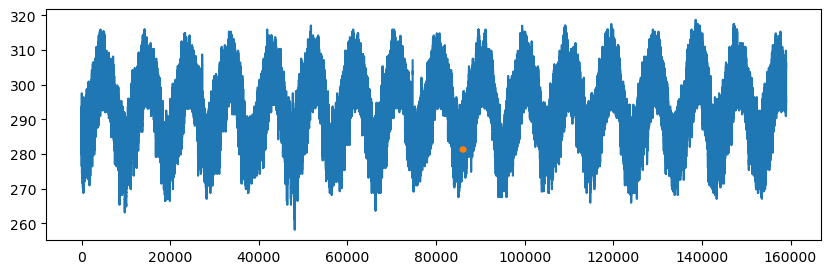

In [201]:
fig,ax = plt.subplots(figsize=(10,3))

df.tas.plot()
df[df['time'].isin(bad)].tas.plot(marker='.', lw=0)

In [202]:
# fig,ax = plt.subplots(figsize=(14,3))

# df.tas.plot()
# df[df['time'].isin(bad)].tas.plot(marker='.', lw=0)
# ax.set_xlim(pd.Timestamp('2015-01-15'), pd.Timestamp('2015-02-15'))
# # ax.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2014-03-01'))

(270.0, 300.0)

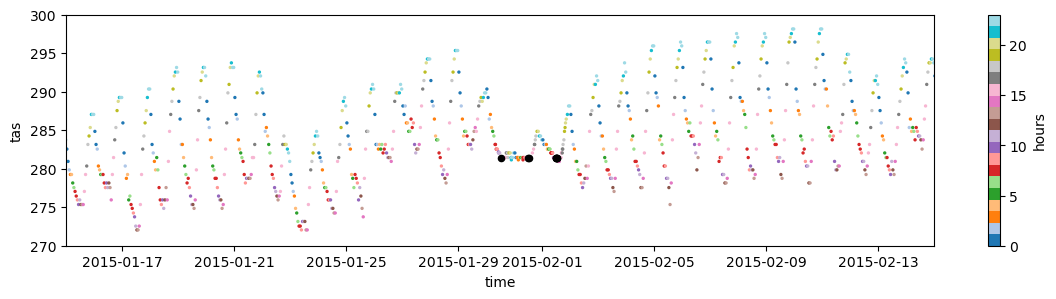

In [214]:
fig,ax = plt.subplots(figsize=(14,3))

df.plot.scatter("time", "tas", ax=ax, c='hours', cmap=mpl.cm.tab20, s=2)
# df[df['time'].isin(bad)].tas.plot(ax=ax, marker='o', mfc="none", lw=0, color="k")
df[df['time'].isin(bad)].plot.scatter("time", "tas", ax=ax, marker='o', color="k")
# ax.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2014-03-01'))
ax.set_xlim(pd.Timestamp('2015-01-15'), pd.Timestamp('2015-02-15'))
ax.set_ylim(270,300)

In [314]:
#---------------------------------------------------------------------------------------------------
def qaqc_unusual_repeated_streaks(df, plot=True, local=False, verbose=True, min_sequence_length=10):
    """
    Test for repeated streaks/unusual spell frequenc. 
    Three test are conducted here:
       - Consecutive observation replication
       - Same hour observation replication over a number of days 
         (either using a threshold of a certain number of observations, 
          or for sparser records, a number of days during which all the
          observations have the same value)
       - Whole day replication for a streak of days
    
    This test is done for ["tas", "tdps", "tdps_derived", "ps", "slp", "sfcWind"]
    
    Input:
    -----
        df [pandas dataframe] : station dataset converted to dataframe through QAQC pipeline
        local [bool] : if True, saves the plot to local directory
        plot [bool] : if True, produces plot and uploads it to AWS
    Output:
    ------
        if qaqc succeded:
            df [pandas dataframe] : QAQC dataframe with flagged values (see below for flag meaning).
        else if qaqc failed:
            None
    Flag meaninig:
    -------------
        27,qaqc_unusual_repeated_streaks,Same hour observation replication over a number of days
        28,qaqc_unusual_repeated_streaks,
        29,qaqc_unusual_repeated_streaks,

    NOTES:
    Threshold for different variables/resolutions are noted on: 
    https://doi.org/10.5194/cp-8-1649-2012 : Table 4
    
    TODO: 
    min_sequence_length can be tweaked, althought HadISD uses 10
    """

    # try:
    if True:
        
        # Infere resolution from data
        resolutions = infere_res(df)
        
        # Save original df multiindex and create station column
        df = df.copy(deep=True)

        # Define test variables and check if they are in the dataframe
        check_vars = ["tas", "tdps", "tdps_derived", "ps", "slp", "sfcWind"]
        # check_vars = ["ps"]
        variables = [var for var in check_vars if var in df.columns]
        
        if verbose:
            print("Running {} on {}".format("qaqc_unusual_repeated_streaks", variables))
        
        # Loop through test variables
        for var in variables:
            # Create a copy of the original dataframe and drop NaNs in the testing variable
            new_df = df.copy(deep=True)
            new_df = new_df.dropna(subset=var)#.drop(columns=["lat","lon","elevation"])
            
            # Use only values that have not been flagged by previous QAQC tests
            valid = np.where(np.isnan(new_df[var+"_eraqc"]))[0]
            new_df = new_df.iloc[valid]
            
            # Choose resolution
            res = resolutions[var]
            
            # --------------------------------------------------------
            # Hour repeat streak criteria
            threshold = hour_repeat_criteria[var][res]
            bad = hourly_repeats(new_df, var, threshold)            
            ind = df['time'].isin(bad)
            df.loc[ind, var+"_eraqc"] = 27    # Flag _eraqc variable
            
            # --------------------------------------------------------
            # Straight repeat streak criteria
            threshold = straight_repeat_criteria[var][res]
            if var=="sfcWind":
                wind_min_value = WIND_MIN_VALUE[res]
            else:
                wind_min_value = None
            bad = consecutive_repeats(new_df, var, threshold, 
                                      wind_min_value, 
                                      min_sequence_length=min_sequence_length)
            ind = df['time'].isin(bad)
            df.loc[ind, var+"_eraqc"] = 28    # Flag _eraqc variable
            
            # --------------------------------------------------------
            # Whole day replica- tion for a streak of days
            threshold = day_repeat_criteria[var][res]
            bad = consecutive_fullDay_repeats(new_df, var, threshold)
            ind = df['time'].isin(bad)
            df.loc[ind, var+"_eraqc"] = 29    # Flag _eraqc variable
            
            # --------------------------------------------------------
            # if plot:
            #     unusual_streaks_plot(df, var, flagval=22, local=local)
            #     for i in ind:
            #         subset = np.logical_and(df.index>=i - np.timedelta64(48,'h'), 
            #                             df.index<=i + np.timedelta64(48,'h'))
            #         unusual_jumps_plot(df[subset], var, flagval=22, date=i, local=local)
        return df
    # except Exception as e:
    #     print("qaqc_unusual_repeated_streaks failed with Exception: {}".format(e))
    #     return None

In [315]:
#---------------------------------------------------------------------------------------------------
# Find clusters of equal values
def select_streaks(x,y):
    """
    """
    if len(y)>0:
        return x[y]
    else:
        return []
    
#---------------------------------------------------------------------------------------------------
# Find clusters of equal values
def find_streaks_index(y, threshold=5):
    """
    """
    y = np.concatenate([y])
    y = y.astype("int")
    y[np.where(y==0)[0]] = 1
    split_indices = np.where(np.diff(y) != 0)[0] + 1
    clusters = np.split(y, split_indices)

    ind = [list(np.arange(split_indices[i-1], split_indices[i-1]+len(clusters[i]), 1)) 
           for i in range(1,len(clusters))]
    result = [i for i in ind if len(i)>threshold]
    
    if len(result)>0:
        return np.concatenate(result)
    else:
        return np.array([])
    
#---------------------------------------------------------------------------------------------------
def hourly_repeats(df, var, threshold):
    """
    Same hour observation replication over a number of days 
         (either using a threshold of a certain number of observations, 
          or for sparser records, a number of days during which all the
          observations have the same value):
          
    1 - Group variable by hour/value
    2 - Count consecutive cluster of repeated values at the same hour of the day
    3 - Select only clusters where count is higher than threshold in dict `hour_repeat_criteria`
    
    This test is done for ["tas", "tdps", "tdps_derived", "ps", "slp", "sfcWind"]
    
    Input:
    -----
        df [pandas dataframe] : station dataset converted to dataframe through QAQC pipeline
        var [str] : variable to test
        threshold [int] : comes from hour_repeat_criteria[var][res]
   Output:
    ------
        bad [numpy array] : dates that mark the flagged values (from df.index)
                  
    NOTES (TODO:)
    """

    # df['hours'] = pd.Series(df.index).dt.hour.values
    df['hours'] = pd.Series(df['time']).dt.hour.values
    # df['times'] = df.index.values
    # counts = pd.DataFrame(df.groupby(by=["hours",var]).apply(lambda x: np.array(x.index.tolist())).rename("dates"))
    counts = pd.DataFrame(df.groupby(by=["hours",var]).apply(lambda x: np.array(x['time'].tolist())).rename("dates"))
    counts['date_diff'] = counts['dates'].transform(lambda x: pd.Series(x).diff().values.astype("timedelta64[D]"))
    counts['streak_index'] = counts['date_diff'].apply(find_streaks_index, args=(7,))
    counts['streaks'] = counts.apply(lambda x: select_streaks(x.dates, x.streak_index), axis=1)
    
    bad = np.concatenate(counts['streaks'].values)
    return bad

In [316]:
#---------------------------------------------------------------------------------------------------
def consecutive_repeats(df, var, threshold, wind_min_value = None, 
                        min_sequence_length = 10):
    """
    Consecutive observation replication 
         (either using a threshold of a certain number of observations, 
          or for sparser records, a number of days during which all the
          observations have the same value):
          
    1 - 
    2 - 
    3 - 
    
    This test is done for ["tas", "tdps", "tdps_derived", "ps", "slp", "sfcWind"]
    
    Input:
    -----
        df [pandas dataframe] : station dataset converted to dataframe through QAQC pipeline
        var [str] : variable to test
        threshold (int,int) : comes from straight_repeat_criteria[var][res]
    Output:
    ------
        bad [numpy array] : dates that mark the flagged values (from df.index)
                  
    NOTES (TODO:)
    """

    da = df[[var,"time"]].copy()
    
    if var=="sfcWind": print(len(da))
    
    # If variable is wind, only use values above min wind value
    if wind_min_value is not None:
        print(wind_min_value)
        da = da[da[var]>wind_min_value]
    if var=="sfcWind": print(len(da))
    # Identify sequences of similar values
    da.loc[:, 'group'] = (da[var] != da[var].shift()).cumsum()
    # da.loc[:, 'start_date'] = da.index.values
    # da.loc[:, 'end_date'] = da.index.values
    da.loc[:, 'start_date'] = da['time'].values
    da.loc[:, 'end_date'] = da['time'].values
    
    start_date = da.copy().groupby([var, 'group']).min().sort_values(by="group").copy()
    end_date   = da.copy().groupby([var, 'group']).max().sort_values(by="group").copy()
    
    # Calculate the length of each sequence
    sequence_lengths = da.copy().groupby([var, 'group']).size().reset_index(name='sequence_length').sort_values(by="group")
    sequence_lengths.loc[:, 'start_date'] = start_date.loc[:, 'start_date'].values
    sequence_lengths.loc[:, 'end_date'] = end_date.loc[:, 'end_date'].values
    
    # Filter sequences with a minimum length
    min_sequence_length = 10
    filtered_sequences = sequence_lengths.copy()[sequence_lengths.loc[:, 'sequence_length'] >= min_sequence_length]
    filtered_sequences.loc[:, 'dt'] = (filtered_sequences.loc[:, 'end_date'] -
                                filtered_sequences.loc[:, 'start_date']).values.astype("timedelta64[D]")
    
    # Get limits
    nvalues, ndays = threshold
    
    #TODO: fix this commented line, 2x sequence_length to test, it should be dt
    condition = np.logical_or(filtered_sequences.loc[:, 'sequence_length'] > nvalues,
                              filtered_sequences['dt'].astype("int") > ndays)
    
    # Find bad groups and index in the original dataset
    bad_groups = filtered_sequences[condition].group.values
    bad = da[da['group'].isin(bad_groups)]['time'].values

    return bad

In [317]:
#---------------------------------------------------------------------------------------------------
def consecutive_fullDay_repeats(df, var, threshold):
    """
    Consecutive observation replication 
         (either using a threshold of a certain number of observations, 
          or for sparser records, a number of days during which all the
          observations have the same value):
          
    1 - 
    2 - 
    3 - 
    
    This test is done for ["tas", "tdps", "tdps_derived", "ps", "slp", "sfcWind"]
    
    Input:
    -----
        df [pandas dataframe] : station dataset converted to dataframe through QAQC pipeline
        var [str] : variable to test
        threshold (int,int) : comes from straight_repeat_criteria[var][res]
    Output:
    ------
        bad [numpy array] : dates that mark the flagged values (from df.index)
                  
    NOTES (TODO:)
    """

    da = df[[var, 'time']].copy()
    # da['date'] = pd.Series(da.index).dt.date.values
    da['date'] = pd.Series(da['time']).dt.date.values

    whole_days = da.groupby(by=['date'])[var].apply(lambda x: " ".join(map(str, np.array(np.round(x.values, decimals=1)))))
    whole_days = pd.DataFrame({var:whole_days, 'date':whole_days.index.values}) 
    
    # TODO: Please comment or delete this line, just for testing
    whole_days.loc[:, 'group'] = (whole_days[var] != whole_days[var].shift()).cumsum()

    # Calculate the length of each sequence
    sequence_lengths = whole_days.copy().groupby([var, 'group']).size().reset_index(name='sequence_length').sort_values(by="group")

    # Filter sequences with a minimum length
    filtered_sequences = sequence_lengths.copy()[sequence_lengths.loc[:, 'sequence_length'] >= threshold]

    bad_groups = filtered_sequences.group
    bad_dates = whole_days[whole_days['group'].isin(bad_groups)]['date']

    # bad = da[da['date'].isin(bad_dates)].index.values
    bad = da[da['date'].isin(bad_dates)]['time'].values

    return bad

In [318]:
ds = xr.open_dataset('train_files/RAWS_ZMBA2.nc').isel(station=0)
ds = xr.open_dataset('train_files/RAWS_PKLC2.nc').isel(station=0)
ds = xr.open_dataset('train_files/ASOSAWOS_72274793084.nc')
df = xarray_to_pandas_qaqc(ds)
df = qaqc_world_record(df)
df['tas'].iloc[11001:11035] = df['tas'].iloc[11000]

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")
/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_18373/1557074058.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tas'].iloc[11001:11035] = df['tas'].iloc[11000]


In [319]:
threshold = straight_repeat_criteria['tas'][0.5]
bad = consecutive_repeats(df, 'tas', threshold)
ind = df['time'].isin(bad)
ind.any()

True

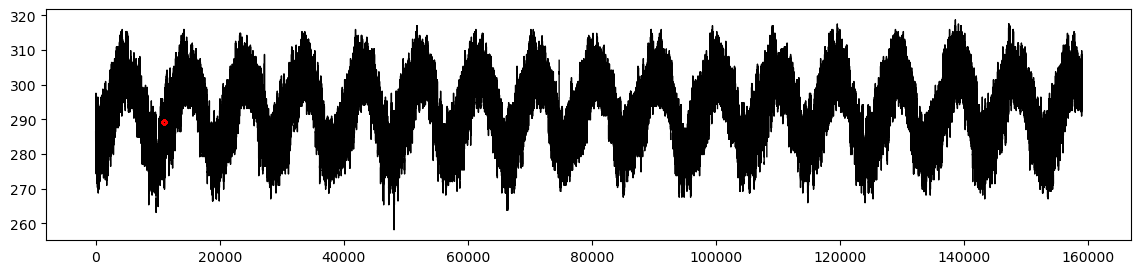

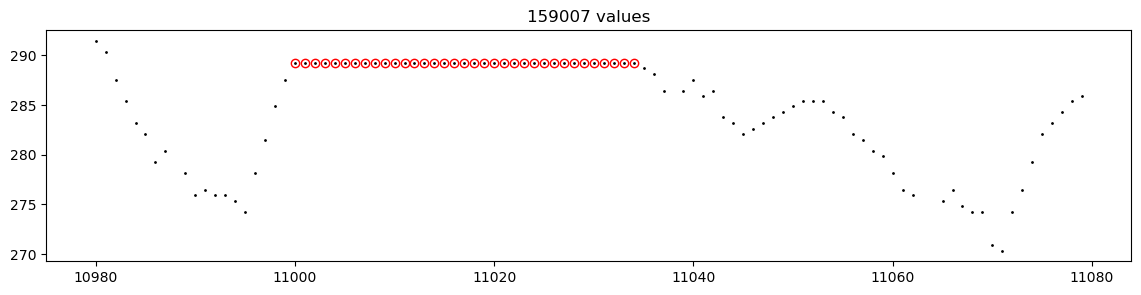

In [320]:
fig,ax = plt.subplots(figsize=(14,3))
df.tas.plot(ax=ax, c="k", lw=1)
# df.tas[ind].plot(ax=ax, marker='o', lw=0, mfc='none', color="red")
df.tas[ind].plot(ax=ax, marker='.', lw=0, mfc='none', color="red")

fig,ax = plt.subplots(figsize=(14,3))
df.iloc[10980:11080].tas.plot(ax=ax, c="k", lw=0, marker=".", ms=2)
df.loc[ind, 'tas'].plot(ax=ax, marker='o', lw=0, mfc='none', color="red")
_ = ax.set_title("{} values".format(len(ind)))

In [321]:
ds = xr.open_dataset('train_files/RAWS_ZMBA2.nc').isel(station=0)
ds = xr.open_dataset('train_files/RAWS_PKLC2.nc').isel(station=0)
ds = xr.open_dataset('train_files/ASOSAWOS_72274793084.nc')
df = xarray_to_pandas_qaqc(ds)
df = qaqc_world_record(df)

df['tas'].iloc[11001:11400] = df['tas'].iloc[11000]

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")
/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_18373/1131924466.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tas'].iloc[11001:11400] = df['tas'].iloc[11000]


In [322]:
threshold = day_repeat_criteria['tas'][0.5]
bad = consecutive_fullDay_repeats(df, 'tas', threshold)
print(len(bad))
ind = df['time'].isin(bad)

300


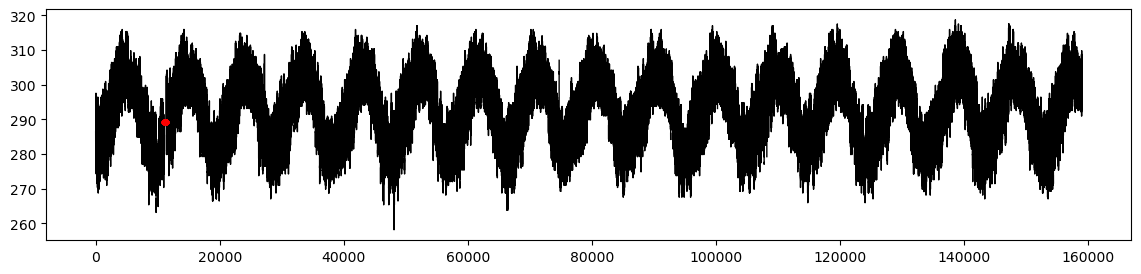

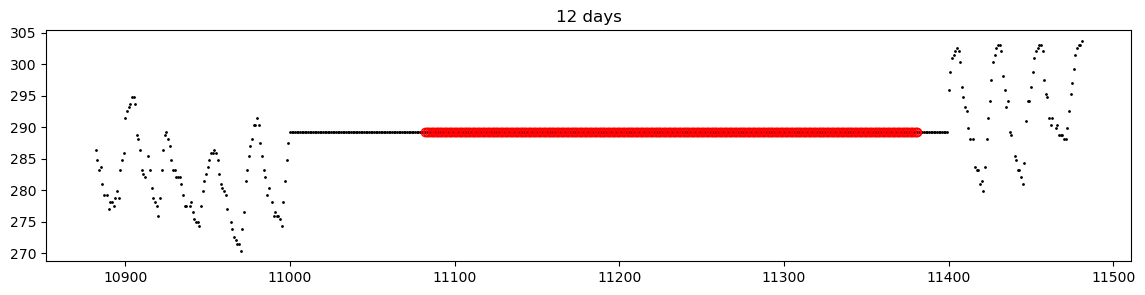

In [323]:
fig,ax = plt.subplots(figsize=(14,3))
df.tas.plot(ax=ax, c="k", lw=1)
# df.tas[bad].plot(ax=ax, marker='o', lw=0, mfc='none', color="red")
df.tas.loc[ind].plot(ax=ax, marker='.', lw=0, mfc='none', color="red")

fig,ax = plt.subplots(figsize=(14,3))
df.tas.loc[min(np.where(ind)[0])-200:max(np.where(ind)[0])+100].plot(ax=ax, c="k", lw=0, marker=".", ms=2)
df.loc[ind].tas.plot(ax=ax, marker='o', lw=0, mfc='none', color="red")
# ax.set_xlim(np.datetime64("2007-02-22"), np.datetime64("2007-03-18"))
_ = ax.set_title("{} days".format(len(bad)//24))

In [324]:
ds = xr.open_dataset('train_files/RAWS_ZMBA2.nc').isel(station=0)
ds = xr.open_dataset('train_files/RAWS_PKLC2.nc').isel(station=0)
ds = xr.open_dataset('train_files/ASOSAWOS_72274793084.nc')
df = xarray_to_pandas_qaqc(ds)
df = qaqc_world_record(df)
df = df.copy()
# df['hours'] = pd.Series(df.index).dt.hour.values
# df['day'] = pd.Series(df.index).dt.day.values
# df['month'] = pd.Series(df.index).dt.month.values
# df['year'] = pd.Series(df.index).dt.year.values
df['hours'] = pd.Series(df['time']).dt.hour.values
df['day'] = pd.Series(df['time']).dt.day.values
df['month'] = pd.Series(df['time']).dt.month.values
df['year'] = pd.Series(df['time']).dt.year.values
condition = np.logical_and(df['hours']==12, np.logical_and(df['month']>2, df['month']<4))
condition = np.logical_and(df['year']==2006, condition)
condition = df[condition].index.values
df.loc[condition, 'tas'] = 300.
len(condition)

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


32

In [325]:
# df[df['hours']==12].tas.iloc[500:590] = 300.
# df[df['hours']==12].tas.iloc[500:590]
# df[condition].tas

In [326]:
threshold = hour_repeat_criteria['tas'][0.5]
print(threshold)
bad = hourly_repeats(df, 'tas', threshold)
print(len(bad))
ind = df['time'].isin(bad)

20
37


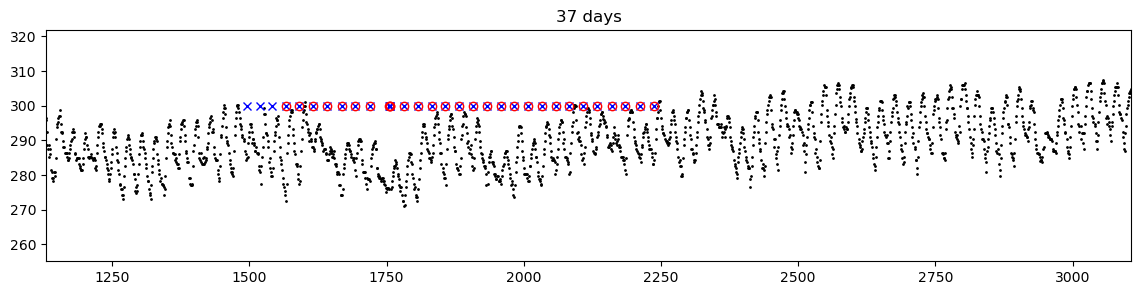

In [327]:
fig,ax = plt.subplots(figsize=(14,3))
df.tas.plot(ax=ax, c="k", lw=0, marker=".", ms=2)
df.loc[condition].tas.plot(ax=ax, marker='x', lw=0, mfc='none', color="blue")
df.loc[ind].tas.plot(ax=ax, marker='o', lw=0, mfc='none', color="red")
x0 = np.where(df['time']<=np.datetime64("2006-02-15"))[0][-1]
x1 = np.where(df['time']<=np.datetime64("2006-05-05"))[0][-1]+1
ax.set_xlim(x0,x1)
_ = ax.set_title("{} days".format(len(bad)))

In [328]:
from calc_qaqc import _plot_format_helper_spikes

In [329]:
#---------------------------------------------------------------------------------------------------
def unusual_streaks_plot(df, var, flagvals=(27,28,29), dpi=None, local=False, date=None):
    """
    Plots unusual large jumps qaqc result and uploads it to AWS (if local, also writes to local folder)
    Input:
    -----
        df [pd.Dataframe] : station pd.DataFrame from qaqc pipeline
        var [str] : variable name
        flagval [int] : flag value to plot (22 for unusual large jumps)
        dpi [int] : resolution for png plots
        local [bool] : if True, saves plot locally, else: only saves plot to AWS
    Ouput:
    ----- 
        None
    """
    
    # grab flagged data
    flag_vals_0 = df.loc[df[var + '_eraqc'] == flagvals[0]]   
    flag_vals_1 = df.loc[df[var + '_eraqc'] == flagvals[1]]   
    flag_vals_2 = df.loc[df[var + '_eraqc'] == flagvals[2]]   
    
    # Create figure
    if date is not None:
        fig,ax = plt.subplots(figsize=(7,3))
    else:
        fig,ax = plt.subplots(figsize=(10,3))

    # Plot variable and flagged data
    df[var].plot(ax=ax, marker=".", ms=4, lw=1, color="k", alpha=0.5, label="Original data")
    
    # Amount of data flagged
    nflags = len(flag_vals_0) + len(flag_vals_1) + len(flag_vals_2)
    title = "{:.4f}% of data flagged".format(100*nflags/len(df))
    flag_label_0 = "Same hour replication"
    flag_label_1 = "Consecutive replication"
    flag_label_2 = "Whole-day replication"
    df.loc[df[var+"_eraqc"]==flagvals[0], var].plot(ax=ax, marker="s", ms=7, lw=0, mfc="none", color="C3", label=flag_label_0)    
    df.loc[df[var+"_eraqc"]==flagvals[1], var].plot(ax=ax, marker="x", ms=7, lw=0, mfc="none", color="C4", label=flag_label_1)    
    df.loc[df[var+"_eraqc"]==flagvals[2], var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C4", label=flag_label_2)    
    legend = ax.legend(loc=0, prop={'size': 8})    
    title = ax.set_title(title)    
        
    station = df['station'].unique()[0]
    network = station.split('_')[0]
    
    # Plot aesthetics
    ylab, units, miny, maxy = _plot_format_helper_spikes(var)
    ylab = '{} [{}]'.format(ylab, units)
    
    ax.set_ylabel(ylab)
    ax.set_xlabel('')
    
    # We can set ylim since this function is supposed to be run after other QAQC functions (including world records)
    if date is not None:
        timestamp = str(date).split(":")[0].replace(" ","T")
    else:
        timestamp = "full_series"
        miny = max(miny, df[var].min())
        maxy = min(maxy, df[var].max())
        ax.set_ylim(miny,maxy)
    
    title = 'Unusual large jumps check: {0}'.format(station)
    ax.set_title(title, fontsize=10)
    
    # save to AWS
    bucket_name = 'wecc-historical-wx'
    directory = '3_qaqc_wx'
    figname = 'qaqc_figs/qaqc_unusual_repeated_streaks_{0}_{1}_{2}'.format(station, var, timestamp)
    key = '{0}/{1}/{2}.png'.format(directory, network, figname)
    img_data = BytesIO()
    fig.savefig(img_data, format='png', dpi=dpi, bbox_inches="tight")
    img_data.seek(0)
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', Key=key)
    plt.close()
    if local:
        fig.savefig(figname+".png", format='png', dpi=dpi, bbox_inches="tight")
    
    return 

In [330]:
ds = xr.open_dataset('train_files/RAWS_ZMBA2.nc').isel(station=0)
ds = xr.open_dataset('train_files/RAWS_PKLC2.nc').isel(station=0)
ds = xr.open_dataset('train_files/ASOSAWOS_72274793084.nc')
df = xarray_to_pandas_qaqc(ds)
df = qaqc_world_record(df)
df['tas'].iloc[11001:11035] = df['tas'].iloc[11000]
df['tas'].iloc[21001:21400] = df['tas'].iloc[21000]
# df['hours'] = pd.Series(df.index).dt.hour.values
# df['day'] = pd.Series(df.index).dt.day.values
# df['month'] = pd.Series(df.index).dt.month.values
# df['year'] = pd.Series(df.index).dt.year.values
df['hours'] = pd.Series(df['time']).dt.hour.values
df['day'] = pd.Series(df['time']).dt.day.values
df['month'] = pd.Series(df['time']).dt.month.values
df['year'] = pd.Series(df['time']).dt.year.values
condition = np.logical_and(df['hours']==12, np.logical_and(df['month']>2, df['month']<4))
condition = np.logical_and(df['year']==2010, condition)
condition = df[condition].index.values
df.loc[condition, 'tas'] = 300.

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")
/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_18373/3679077418.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tas'].iloc[11001:11035] = df['tas'].iloc[11000]
/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_18373/3679077418.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

In [331]:
newdf = qaqc_unusual_repeated_streaks(df, plot=False, local=False, verbose=True, min_sequence_length=10)

Running qaqc_unusual_repeated_streaks on ['tas', 'tdps', 'ps', 'sfcWind']
151621
0.5
131540


In [332]:
(
  newdf['tas_eraqc'].dropna().any(),
  newdf['tdps_eraqc'].dropna().any(),
  newdf['sfcWind_eraqc'].dropna().any(),
  newdf['ps_eraqc'].dropna().any(),
)

(True, False, True, False)

In [333]:
## Import Libraries
import boto3
from io import BytesIO, StringIO

In [334]:
var = "tas"
unusual_streaks_plot(newdf, var, flagvals=(27,28,29), dpi=None, local=True, date=None)

In [335]:
var = "sfcWind"
unusual_streaks_plot(newdf, var, flagvals=(27,28,29), dpi=None, local=True, date=None)

In [336]:
ind = newdf['sfcWind_eraqc']==27
newdf[ind][['time','sfcWind']]

,time,sfcWind
94655,2015-12-23 15:07:00,0.0
94656,2015-12-23 15:51:00,0.0
94702,2015-12-24 15:10:00,0.0
94703,2015-12-24 15:13:00,0.0
94704,2015-12-24 15:20:00,0.0
94705,2015-12-24 15:32:00,0.0
94706,2015-12-24 15:51:00,0.0
94737,2015-12-25 15:43:00,0.0
94738,2015-12-25 15:49:00,0.0
